# Machine Learning

This notebook will address the pre-processing issues I encountered in the last notebook where my test data ended up having different dummy columns in the encoding, causing the model not to fit.

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',None)

In [4]:
# Load data
df_original = pd.read_csv('./Data/train.csv')

# Load the test data too
df_original_test = pd.read_csv('./Data/test.csv')

df_original.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [62]:
value_counts_original = {}

for column in df_original.select_dtypes(include=['object', 'category']).columns:
    value_counts_original[column] = df_original[column].unique()

print(value_counts_original)

{'MSZoning': array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object), 'Street': array(['Pave', 'Grvl'], dtype=object), 'Alley': array(['None', 'Grvl', 'Pave'], dtype=object), 'LotShape': array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object), 'LandContour': array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object), 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object), 'LotConfig': array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object), 'LandSlope': array(['Gtl', 'Mod', 'Sev'], dtype=object), 'Neighborhood': array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object), 'Condition1': array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object), 'Condition2': array(['Norm', 'Artery', 'RRNn', 'F

In [73]:
columns_to_look_at = []

for column in df_original_test.select_dtypes(include=['object', 'category']).columns:
    if(set(value_counts_original[column]) != set(df_original_test[column].unique())):
        columns_to_look_at.append(column)

print(len(columns_to_look_at))
print(len(df_original_test.select_dtypes(include=['object', 'category']).columns))

22
43


## Data Exploration

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df_original.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

Percentage of Rows with NAs in column:

LotFrontage      17.73% \
Alley            93.76% \
MasVnrType       59.72% \
MasVnrArea        0.54% \
BsmtQual          2.53% \
BsmtCond          2.53% \
BsmtExposure      2.60% \
BsmtFinType1      2.53% \
Electrical        0.06% \
FireplaceQu      47.26% \
GarageType        5.54% \
GarageYrBlt       5.54% \
GarageFinish      5.54% \
GarageQual        5.54% \
GarageCond        5.54% \
PoolQC           99.52% \
Fence            80.75% \
MiscFeature      96.30%

In [7]:
df_original.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

I think what I need to do is fill in the NAs with 'None' for the following columns:

Alley            93.76% \
MasVnrType       59.72% \
FireplaceQu      47.26% \
PoolQC           99.52% \
Fence            80.75% \
MiscFeature      96.30% \

In [8]:
# Define some column transformations

def fill_na_columns(df):
    df['Alley'] = df['Alley'].fillna('None')
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
    df['PoolQC'] = df['PoolQC'].fillna('None')
    df['Fence'] = df['Fence'].fillna('None')
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    df['GarageType'] = df['GarageType'].fillna('None')
    df['GarageFinish'] = df['GarageFinish'].fillna('None')
    df['GarageQual'] = df['GarageQual'].fillna('None')
    df['GarageCond'] = df['GarageCond'].fillna('None')
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    return df

df_modified = fill_na_columns(df_original)

In [9]:
df_modified.isna().sum()

Id                0
MSSubClass        0
MSZoning          0
LotFrontage       0
LotArea           0
Street            0
Alley             0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
MasVnrArea        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinSF1        0
BsmtFinType2     38
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0


Now that most of the NAs are resolved, I'll split out the target variable and drop other unecessary columns from the analysis.

In [10]:
# Pull out the target variable
y = df_modified['SalePrice']

df_modified = df_modified.drop('SalePrice', axis=1)

print('df_modified shape', df_modified.shape)

# Now I copy in the test datframe
df_combined = pd.concat([df_modified, df_original_test])

print('df_combined shape', df_combined.shape)

df_modified shape (1460, 80)
df_combined shape (2919, 80)


# Data Preprocessing

In [37]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

df_combined_categorical = df_combined.select_dtypes(include=['object', 'category'])
df_combined_numeric = df_combined.select_dtypes(exclude=['object', 'category'])

print(df_combined_categorical.shape)
print(df_combined_numeric.shape)


(2919, 43)
(2919, 37)


In [40]:
encoder = OneHotEncoder(sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df_combined_categorical))


c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
print(df_combined_categorical.shape)
print(df_encoded.shape)

(2919, 43)
(2919, 284)


In [47]:
# Resetting the indices
df_encoded_reset = df_encoded.reset_index(drop=True)
df_numeric_reset = df_combined_numeric.reset_index(drop=True)

# Concatenating the DataFrames
df_recombined = pd.concat([df_encoded_reset, df_numeric_reset], axis=1)

In [48]:
df_recombined.shape

(2919, 321)

In [50]:
df_recombined_train = df_recombined.iloc[:1460]
df_recombined_test_data = df_recombined.iloc[1460:]

print(df_recombined_train.shape)
print(df_recombined_test_data.shape)

(1460, 321)
(1459, 321)


In [53]:
df_recombined_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0

In [60]:
df_recombined_test_data.isna().sum()

0                  0
1                  0
2                  0
3                  0
4                  0
5                  0
6                  0
7                  0
8                  0
9                  0
10                 0
11                 0
12                 0
13                 0
14                 0
15                 0
16                 0
17                 0
18                 0
19                 0
20                 0
21                 0
22                 0
23                 0
24                 0
25                 0
26                 0
27                 0
28                 0
29                 0
30                 0
31                 0
32                 0
33                 0
34                 0
35                 0
36                 0
37                 0
38                 0
39                 0
40                 0
41                 0
42                 0
43                 0
44                 0
45                 0
46                 0
47           

In [ ]:
#from sklearn.pipeline import make_pipeline
#from sklearn.compose import make_column_transformer
#from sklearn.linear_model import LogisticRegression

#column_trans = make_column_transformer(
#    (OneHotEncoder(), ['Sex', 'Embarked']),
#    remainder='passthrough')

#logreg = LogisticRegression(solver='lbfgs')
#pipe = make_pipeline(column_trans, logreg)

Now that the data is cleaned up, time to make some models.

## Data Splitting

In [57]:
X = df_recombined_train.copy()
X.columns = X.columns.astype(str)
print(X.shape, y.shape)

(1460, 321) (1460,)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
lr = LinearRegression()

lr.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Use the model to make predictions

In [23]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [24]:
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

print('LR MSE (Train): ', lr_train_mse)
print('LR R2 (Train): ', lr_train_r2)
print('LR MSE (Test): ', lr_test_mse)
print('LR R2 (Test): ', lr_test_r2)

LR MSE (Train):  401906456.45393795
LR R2 (Train):  0.934414017939047
LR MSE (Test):  2475138483.7664924
LR R2 (Test):  0.6401921234517328


In [27]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,401906456.453938,0.934414,2475138483.766492,0.640192


# Random Forest

In [36]:
rf = RandomForestRegressor(max_depth=12, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, random_state=42)

In [37]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

In [38]:
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random Forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest,134553269.946698,0.978043,1228805191.156249,0.82137


# Compare models

In [39]:
df_model = pd.concat([lr_results, rf_results], axis=0).reset_index(drop=True)
df_model

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,401906456.453938,0.934414,2475138483.766492,0.640192
1,Random Forest,134553269.946698,0.978043,1228805191.156249,0.82137


# Visualize

Text(0.5, 0, 'Actual Sale Price')

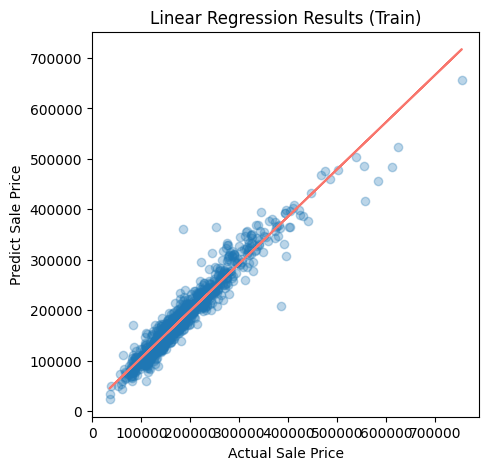

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_lr_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_lr_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Linear Regression Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

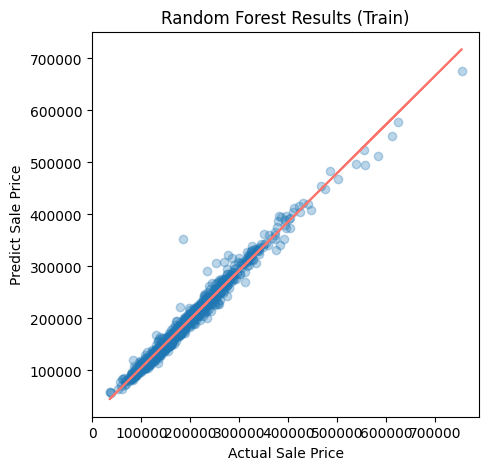

In [41]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_rf_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Random Forest Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

It looks like the linear regression does better on the training sets, but random forest should do better on the test data.

Text(0.5, 0, 'Actual Sale Price')

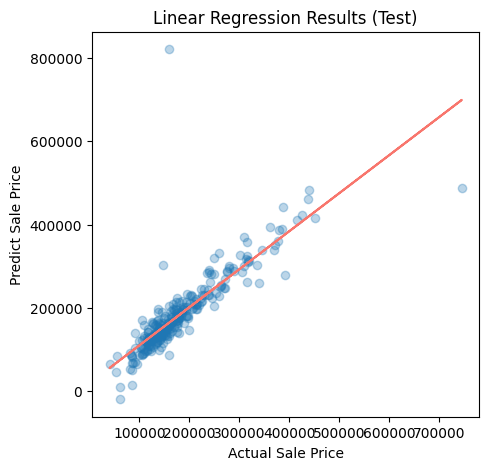

In [42]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_test, y=y_lr_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_lr_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Linear Regression Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

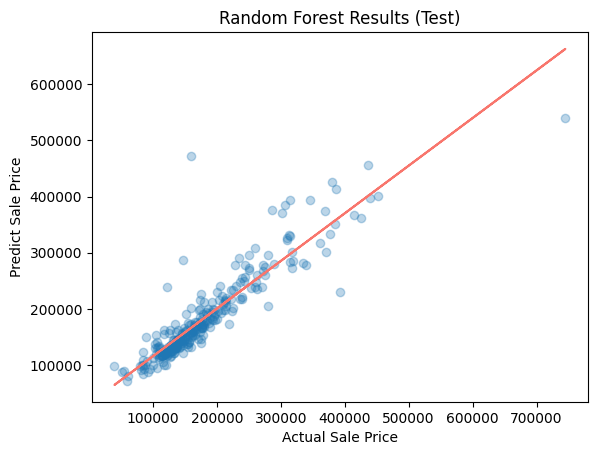

In [43]:
plt.scatter(x=y_test, y=y_rf_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_rf_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Random Forest Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

These models look better than before. Especially the Random Forest. I think it was important to increase that max depth. I could use a GridSearch to make it a little better

In [44]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rf_gs = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=3, refit='r2')

# Fit the grid search to the data (replace 'X_train' and 'y_train' with your data)
grid_search.fit(X_train, y_train)

c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='r2')

Now lets look for the best params and best score

In [45]:
print('Best Params: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)
print('Best Est: ', grid_search.best_estimator_)

Best Params:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:  0.8523649360887049
Best Est:  RandomForestRegressor(max_features='sqrt')


Now lets create a Random Forest Regressor with the best params

In [48]:
rf_optimal = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rf_optimal.fit(X_train,y_train)

y_rf_optimal_train_pred = rf_optimal.predict(X_train)
y_rf_optimal_test_pred = rf_optimal.predict(X_test)

rf_optimal_train_mse = mean_squared_error(y_train, y_rf_optimal_train_pred)
rf_optimal_train_r2 = r2_score(y_train, y_rf_optimal_train_pred)

rf_optimal_test_mse = mean_squared_error(y_test, y_rf_optimal_test_pred)
rf_optimal_test_r2 = r2_score(y_test, y_rf_optimal_test_pred)

rf_optimal_results = pd.DataFrame(['Random Forest Optimal', rf_optimal_train_mse, rf_optimal_train_r2, rf_optimal_test_mse, rf_optimal_test_r2]).transpose()
rf_optimal_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

rf_optimal_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest Optimal,132227005.129909,0.978422,1004170829.435402,0.854025


In [49]:
df_model = pd.concat([df_model, rf_optimal_results], axis=0).reset_index(drop=True)
df_model

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,401906456.453938,0.934414,2475138483.766492,0.640192
1,Random Forest,134553269.946698,0.978043,1228805191.156249,0.82137
2,Random Forest Optimal,132227005.129909,0.978422,1004170829.435402,0.854025


# Visualize

Text(0.5, 0, 'Actual Sale Price')

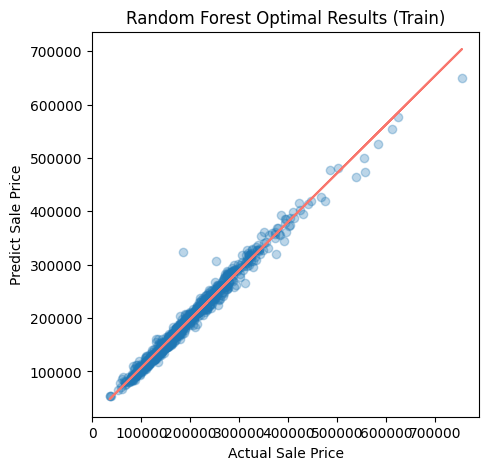

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_optimal_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_rf_optimal_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Random Forest Optimal Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

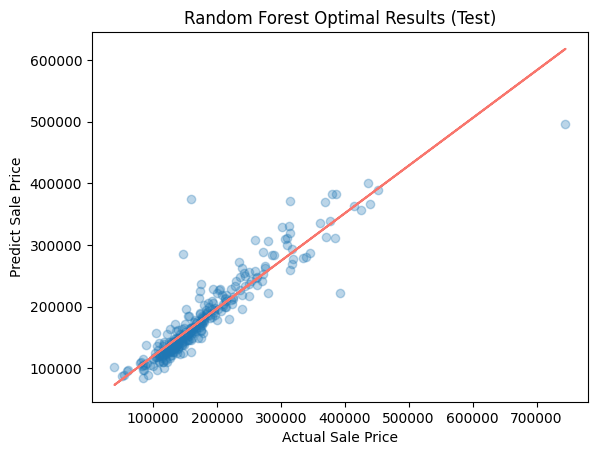

In [51]:
plt.scatter(x=y_test, y=y_rf_optimal_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_rf_optimal_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Random Forest Optimal Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

# Create prediction for test

In [52]:
test_df = pd.read_csv('./Data/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Now we need to make a copy and apply the same transformations on the test_df

In [54]:
test_df_copy = test_df.copy()

test_df_copy['Alley'] = test_df_copy['Alley'].fillna('None')
test_df_copy['MasVnrType'] = test_df_copy['MasVnrType'].fillna('None')
test_df_copy['FireplaceQu'] = test_df_copy['FireplaceQu'].fillna('None')
test_df_copy['PoolQC'] = test_df_copy['PoolQC'].fillna('None')
test_df_copy['Fence'] = test_df_copy['Fence'].fillna('None')
test_df_copy['MiscFeature'] = test_df_copy['MiscFeature'].fillna('None')

test_df_copy['GarageType'] = test_df_copy['GarageType'].fillna('None')
test_df_copy['GarageFinish'] = test_df_copy['GarageFinish'].fillna('None')
test_df_copy['GarageQual'] = test_df_copy['GarageQual'].fillna('None')
test_df_copy['GarageCond'] = test_df_copy['GarageCond'].fillna('None')
test_df_copy['GarageYrBlt'] = test_df_copy['GarageYrBlt'].fillna(test_df_copy['YearBuilt'])

test_df_copy['LotFrontage'] = test_df_copy['LotFrontage'].fillna(df_original['LotFrontage'].median())

test_df_copy = test_df_copy.drop(columns=['Id'], axis=1)

test_df_copy = pd.get_dummies(test_df_copy, drop_first=True)

In [55]:
test_df['SalePrice'] = rf_optimal.predict(test_df_copy)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Exterior1st_AsphShn
- Foundation_Slab
- Heating_Wall
Feature names seen at fit time, yet now missing:
- Condition2_RRAe
- Condition2_RRAn
- Condition2_RRNn
- Electrical_Mix
- Exterior1st_ImStucc
- ...


This didn't quite work. The get_dummies encoding on the training set didn't have all of the same columns.

I should take the test and train datasets and figure out which columns have different value sets programmatically. Something like create a dictionary of df.column_name -> unique_values for both sets, then compare the dictionaries.